https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.dynamic_factor_mq.DynamicFactorMQ.html
<br>https://medium.com/@philippetousignant/dynamic-factor-models-in-python-58d2d5252640
<br>https://www.ecb.europa.eu/pub/pdf/scpwps/ecbwp1564.pdf

In [1]:
import datetime
import requests
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import warnings
from statsmodels.tsa.arima.model import ARIMA

Static data

In [2]:
source_file = 'Data Sources.csv'

In [3]:
train_ratio = 0.8
max_factors, max_lags = 5, 2
max_ar = 9
forecast_steps = 1

Classes and functions

In [4]:
class Variables:
    def __init__(self, df):
        self.dep = df[df['Dependent']=='Y']['Name'].tolist()

        self.indep = df[df['Dependent']!='Y']['Name'].tolist()
        self.indep = [i for i in self.indep if 'business expectations' not in i.lower()]

        self.freq = dict(zip(df['Name'],df['Frequency']))

        self.non_stat = []

In [5]:
def get_dos(url):
    response = requests.get(url=url).json()
    return({i['Key']:float(i['Value']) for i in response})

In [6]:
def get_sgx(url):
    data = {}
    response = requests.get(url=url).json()
    for d in response['data']:
        date = d['trading_time'].split('_')[0]
        date = datetime.datetime.strptime(date, '%Y%m%d').date()
        data[date] = float(d['lp'])
    return(data)

In [7]:
def get_mas(url, params={'fields':'end_of_month,m1','limit':100,'offset':0}):
    response = requests.get(url=url, params=params).json()

    no_records = int(response['result']['total'])
    pagesize = int(response['result']['limit'])
    pages = no_records//pagesize + (no_records%pagesize>0)

    # parse first page
    data = {}
    for i in response['result']['records']:
        data[i['end_of_month']] = float(i['m1'])

    # parse rest of data to get complete series
    for i in range(1,pages):
        params['offset'] = i*100
        response = requests.get(url=url, params=params).json()
        for i in response['result']['records']:
            data[i['end_of_month']] = float(i['m1'])

    return(data)

In [8]:
def run_df(data, no_factors, f_lags):
    try:
        model = sm.DynamicFactorMQ(endog=data,
                                   k_endog_monthly=len([k for k,v in variables.freq.items() if v=='M']),
                                   factors=no_factors, factor_orders=f_lags,
                                   idiosyncratic_ar1=True)
        results = model.fit(maxiter=100, disp=False)
        return(results)

    except UserWarning:
        return(None)

In [9]:
def find_min_ic(models_dict):
    # info criterion type: (model specifications, info criterion value)
    ic_min = {ic:(None,float('inf')) for ic in ics}

    # k: model specifications, v: model object
    for k,v in models_dict.items():
        for ic,val in ic_min.items():
            if v[ic]<ic_min[ic][1]:
                ic_min[ic] = (k,v[ic])
    return(ic_min)

In [10]:
def compare(actual_df, predict_df):
    compare_df = pd.DataFrame(actual_df[variables.dep].dropna().values,
                              index=actual_df[variables.dep].dropna().index,
                              columns=['Actual'])

    compare_df = compare_df.merge(predict_df[variables.dep].rename(columns={variables.dep[0]:'Predicted'}),
                                  how='left', left_index=True, right_index=True)
    return(compare_df)

In [11]:
def split_train_test(data, train_prop):
    train_no_rows = round(train_prop * len(data))
    train_df = data.iloc[:train_no_rows]
    test_df = data.iloc[train_no_rows:]
    return(train_df, test_df)

In [12]:
def run_train_test(full_data, train_data, forecast_steps, factor, lag):
    fc_df = pd.DataFrame()
    model = run_df(train_data, factor, lag)
    if not model:
        return(None) # exit func if model does not converge

    for i in range(-(len(full_data)-len(train_data)), 0, forecast_steps):
        model = model.apply(endog=full_data.iloc[:i])
        forecast = model.forecast(steps=forecast_steps)
        fc_df = pd.concat([fc_df, forecast])

    export = {'model':model, 'forecasts':fc_df}

    for ic in ics:
        export[ic] = getattr(model, ic)

    return(export)

Load raw data

In [13]:
sources = pd.read_csv(source_file, encoding='utf-8')
variables = Variables(sources)

In [14]:
requests_funcs = {'mas':get_mas, 'sgx':get_sgx, 'singstat':get_dos}

In [15]:
apis = {'mas':[], 'sgx':[], 'singstat':[]}
for k in apis.keys():
    for i in zip(sources['Name'], sources['Frequency'], sources['API']):
        if k in i[-1]:
            apis[k].append({'Name':i[0], 'Frequency':i[1], 'API':i[2]})

In [16]:
# pull data
ts_data = {}
for k,v in apis.items():
    for dim in v:
        ts_data[dim['Name']] = requests_funcs[k](dim['API'])

In [17]:
# pass data into pandas series
ts_pd = {}
for k,v in apis.items():
    for dim in v:

        if dim['Frequency']=='Q' and k=='singstat':
            periods = [p.split()[0]+p.split()[-1][::-1] for p in list(ts_data[dim['Name']])]
            periods = pd.PeriodIndex(periods, freq=dim['Frequency'])
            ts_pd[dim['Name']] = pd.Series(ts_data[dim['Name']].values(), index=periods)

        elif dim['Frequency']=='M':
            periods = pd.to_datetime(list(ts_data[dim['Name']])) + pd.tseries.offsets.MonthEnd(0)
            ts_pd[dim['Name']] = pd.Series(ts_data[dim['Name']].values(), index=periods)

        elif dim['Frequency']=='D' and k=='sgx':
            periods = pd.to_datetime(list(ts_data[dim['Name']]))
            ts_pd[dim['Name']] = pd.Series(ts_data[dim['Name']].values(), index=periods).resample('M').last()
            variables.freq[dim['Name']] = 'M' # update to 'M' since resampled

Check and ensure series' stationarity

In [18]:
# if p-value >0.05, var is non-stationary
for i in variables.indep:

    # if unit root, take % yoy growth (which also removes seasonality)
    if adfuller(ts_pd[i])[1]>0.05:

        if variables.freq[i]=='M':
            ts_pd[i] = ts_pd[i].pct_change(periods=12) * 100
        elif variables.freq[i]=='Q':
            ts_pd[i] = ts_pd[i].pct_change(periods=4) * 100
        print(f'[Non-stationary] {i}')
        variables.non_stat.append(i)

    else:
        print(f'[Stationary] {i}')

[Non-stationary] Composite Leading Index (2015 = 100)
[Non-stationary] Domestic Wholesale Trade Index, (2017 = 100), In Chained Volume Terms
[Non-stationary] Foreign Wholesale Trade Index, (2017 = 100), In Chained Volume Terms
[Non-stationary] Business Receipts Index For Services Industries, (2014=100)
[Non-stationary] Food & Beverage Services Index, (2017 = 100), In Chained Volume Terms
[Non-stationary] Retail Sales Index, (2017 = 100), In Chained Volume Terms
[Non-stationary] Tourism Receipts By Major Components (Year-To-Date)
[Non-stationary] Sea Cargo And Shipping Statistics (Total Cargo)
[Stationary] Air Cargo Tonnage
[Non-stationary] Domestic Exports By Commodity Division
[Non-stationary] Merchandise Imports By Commodity Division
[Stationary] Straits Times Index (STI)
[Non-stationary] M1 Money Supply
[Non-stationary] Index Of Industrial Production (2019 = 100)


Resample all series and pass into dataframe (order must be adhered to as defined by statsmodels docs):
- dependent variable leftmost
- monthly data in the first columns
- quarterly data in the last columns

In [19]:
# resample all series to monthly and start from first valid index
for series, freq in zip(sources['Name'], sources['Frequency']):

    if freq=='Q':
        ts_pd[series] = ts_pd[series].resample('M', convention='end').asfreq()
        ts_pd[series].index = pd.to_datetime(ts_pd[series].index.strftime('%Y-%m-%d'))

    if ts_pd[series].index[0]!=ts_pd[series].first_valid_index():
        ts_pd[series] = ts_pd[series][ts_pd[series].first_valid_index():]

In [20]:
# pass all series into dataframe, start dataframe from first year of GDP growth data
ts_df = pd.DataFrame(ts_pd)
ts_df = ts_df.loc[ts_df.index.year>=ts_df.loc[:,variables.dep[0]].first_valid_index().year]

# rearrange columns in correct order for factor modelling as explained in markdown above
ts_df = ts_df[variables.dep+\
              [k for k,v in variables.freq.items() if v=='M' and k!=variables.dep[0]]+\
              [k for k,v in variables.freq.items() if v=='Q' and k!=variables.dep[0]]]
ts_df

,"Gross Domestic Product, Year On Year Growth Rate","Food & Beverage Services Index, (2017 = 100), In Chained Volume Terms","Retail Sales Index, (2017 = 100), In Chained Volume Terms",Sea Cargo And Shipping Statistics (Total Cargo),Air Cargo Tonnage,Domestic Exports By Commodity Division,Merchandise Imports By Commodity Division,Straits Times Index (STI),M1 Money Supply,Index Of Industrial Production (2019 = 100),Composite Leading Index (2015 = 100),Business Expectations Of The Manufacturing Sector - Forecast By Industry,"Business Expectations For The Services Sector - Operating Receipts Forecast For The Next Quarter, Weighted Percentages Of Up, Same, Down","Business Expectations For The Services Sector - General Business Outlook For The Next 6 Months, Weighted Percentages Of Up, Same, Down","Domestic Wholesale Trade Index, (2017 = 100), In Chained Volume Terms","Foreign Wholesale Trade Index, (2017 = 100), In Chained Volume Terms","Business Receipts Index For Services Industries, (2014=100)",Tourism Receipts By Major Components (Year-To-Date)
1976-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976-03-31,10.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.0,NaN,NaN,NaN,NaN,NaN,NaN
1976-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-31,NaN,27.177935,7.230170,-3.506041,152297.0,6.472918,10.924407,3093.11,NaN,-0.983467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-30,NaN,16.412108,3.072469,-10.358495,150754.0,-5.681441,-0.041443,3290.49,NaN,-4.109938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31,6.2,6.585394,3.762024,0.712782,152562.0,-6.333608,-8.242208,3251.32,NaN,-2.643682,-5.431879,-25.0,3.0,3.0,-0.279196,1.153111,10.865381,NaN
2023-01-31,NaN,NaN,NaN,-8.586840,NaN,-9.527142,-11.260215,3365.67,NaN,-2.677457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Explore data

In [21]:
ts_df.describe().round(3)

,"Gross Domestic Product, Year On Year Growth Rate","Food & Beverage Services Index, (2017 = 100), In Chained Volume Terms","Retail Sales Index, (2017 = 100), In Chained Volume Terms",Sea Cargo And Shipping Statistics (Total Cargo),Air Cargo Tonnage,Domestic Exports By Commodity Division,Merchandise Imports By Commodity Division,Straits Times Index (STI),M1 Money Supply,Index Of Industrial Production (2019 = 100),Composite Leading Index (2015 = 100),Business Expectations Of The Manufacturing Sector - Forecast By Industry,"Business Expectations For The Services Sector - Operating Receipts Forecast For The Next Quarter, Weighted Percentages Of Up, Same, Down","Business Expectations For The Services Sector - General Business Outlook For The Next 6 Months, Weighted Percentages Of Up, Same, Down","Domestic Wholesale Trade Index, (2017 = 100), In Chained Volume Terms","Foreign Wholesale Trade Index, (2017 = 100), In Chained Volume Terms","Business Receipts Index For Services Industries, (2014=100)",Tourism Receipts By Major Components (Year-To-Date)
count,188.000,444.000,444.000,325.000,276.000,553.000,553.000,146.000,354.000,469.000,176.000,188.000,112.000,112.000,108.000,108.000,80.000,55.000
mean,8.776,1.116,4.469,2.603,152153.746,9.288,8.634,3104.498,10.471,6.894,3.394,10.638,5.366,4.920,0.665,5.024,5.879,18.683
std,7.185,9.798,12.835,7.078,17261.072,16.715,14.963,242.879,8.414,11.360,6.325,18.517,14.543,18.982,7.944,5.832,6.491,114.536
min,-14.700,-51.778,-52.322,-20.104,95838.000,-38.103,-33.492,2423.840,-11.783,-32.247,-11.610,-57.000,-53.000,-58.000,-22.732,-7.093,-13.939,-89.451
25%,4.975,-2.977,-2.863,-1.599,141520.250,-2.313,-1.269,2982.445,4.697,-0.188,-0.113,0.000,-1.000,-3.250,-4.258,1.148,2.552,-10.581
50%,9.500,1.592,2.677,2.906,153389.000,9.495,8.964,3166.140,9.790,6.720,3.092,13.000,8.000,7.500,0.807,4.646,5.511,2.126
75%,13.900,5.025,9.795,7.158,162541.500,19.166,18.485,3267.702,16.051,13.627,7.087,24.000,13.250,18.250,5.723,9.137,9.403,16.229
max,29.600,69.221,82.068,20.310,191677.000,72.327,57.894,3613.930,42.414,58.639,21.330,54.000,30.000,36.000,21.387,18.609,18.750,652.857


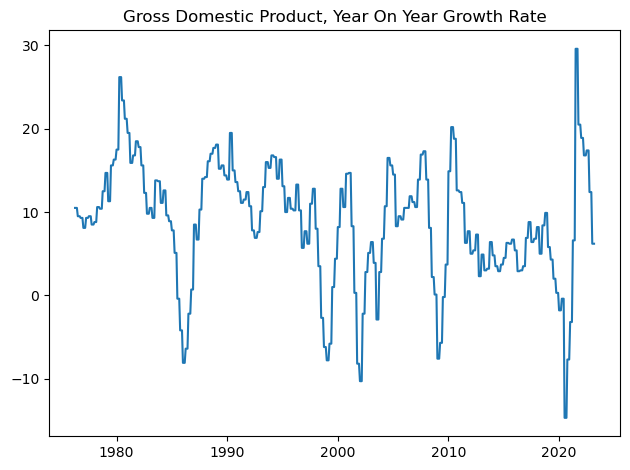

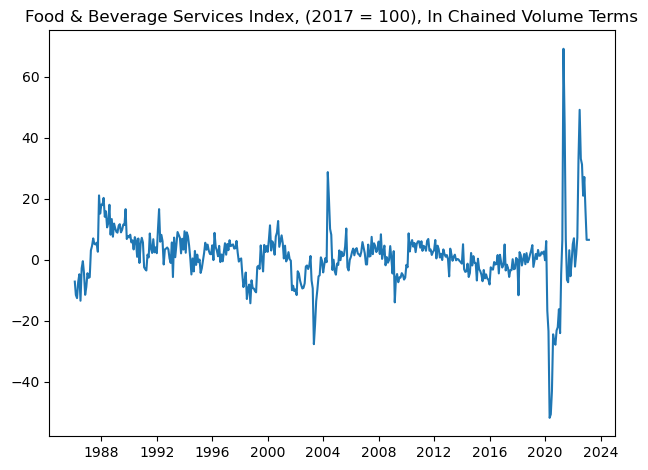

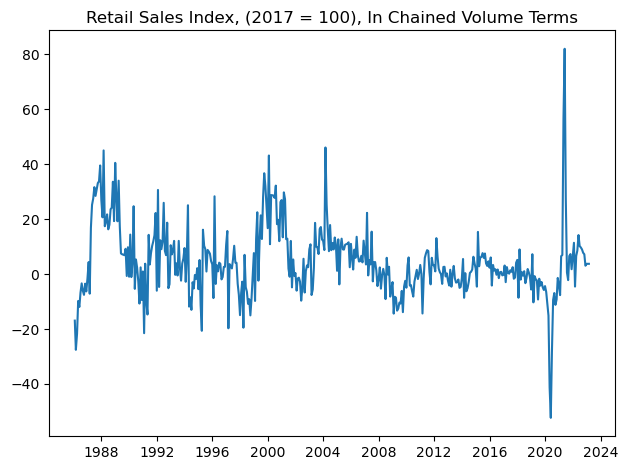

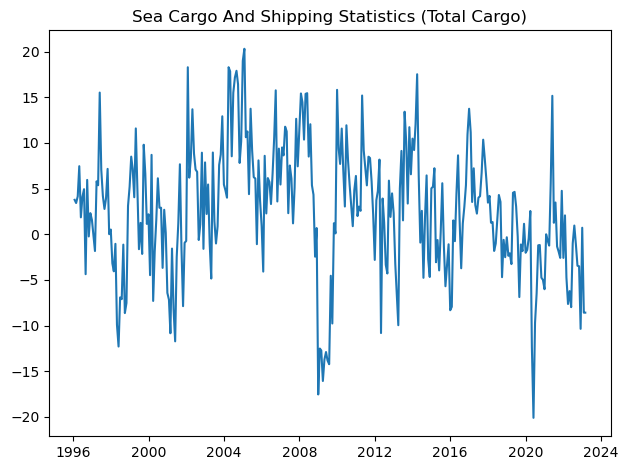

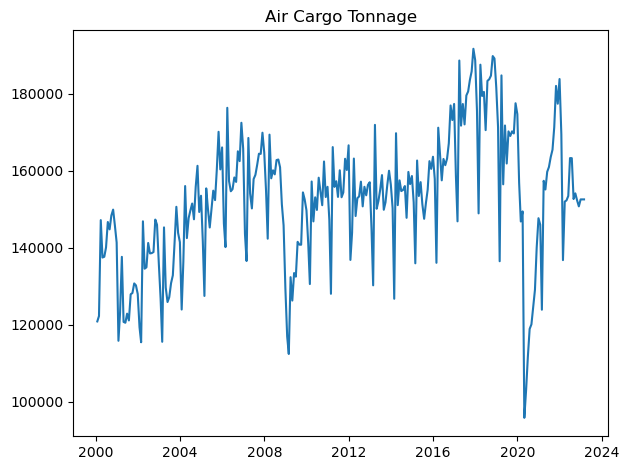

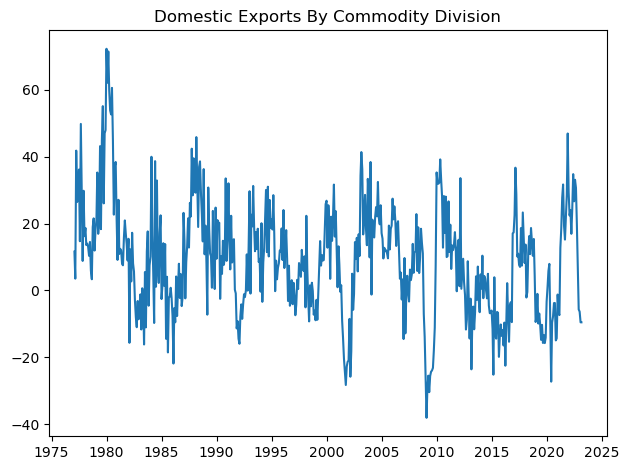

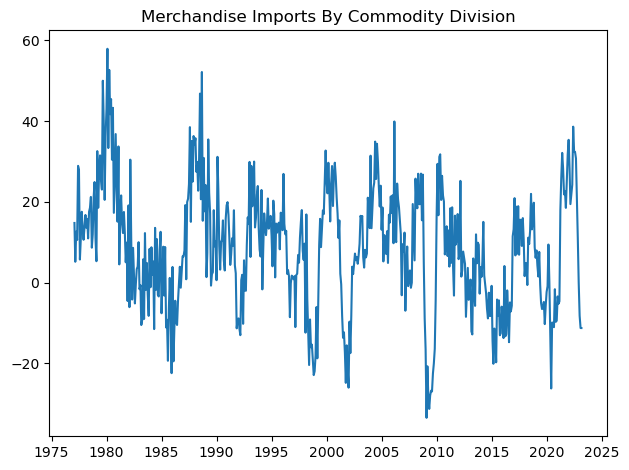

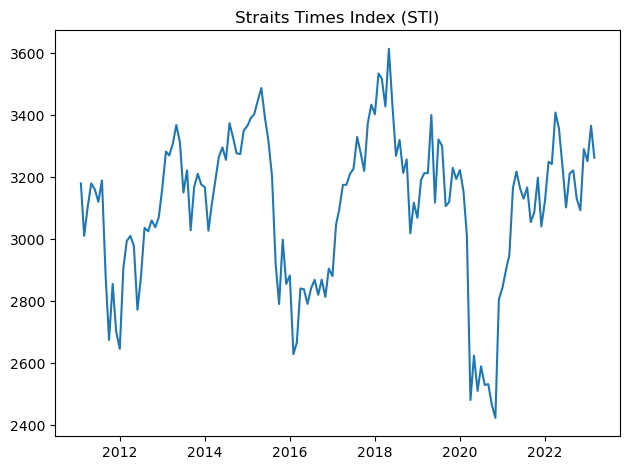

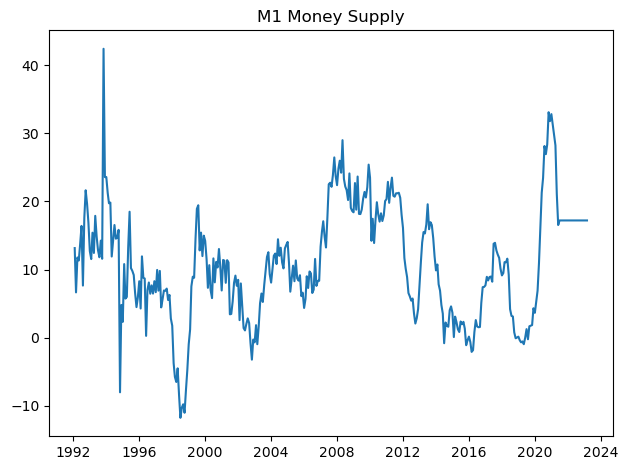

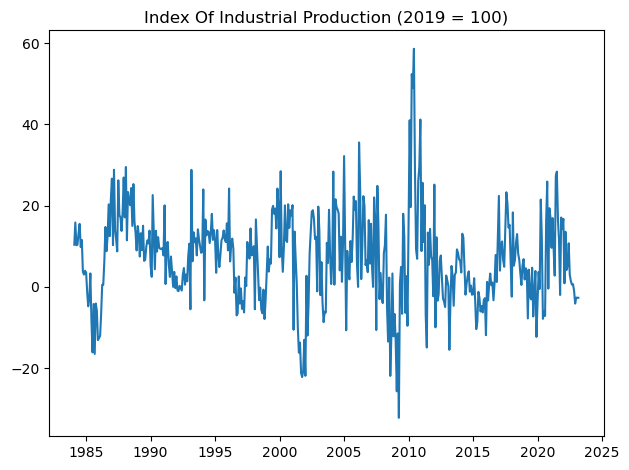

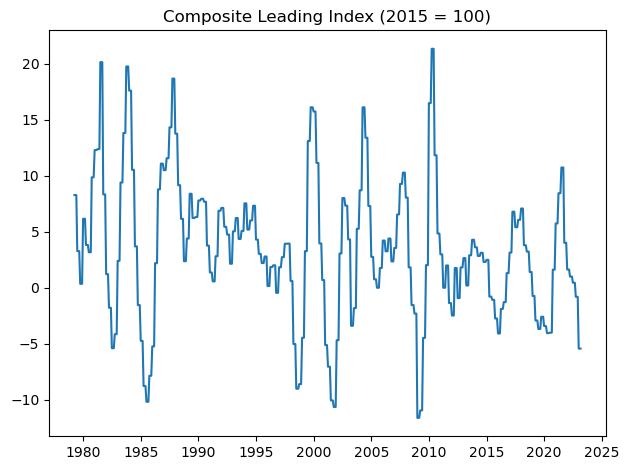

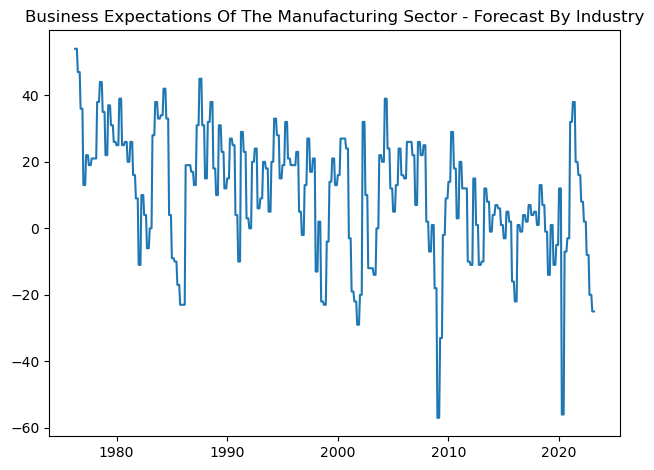

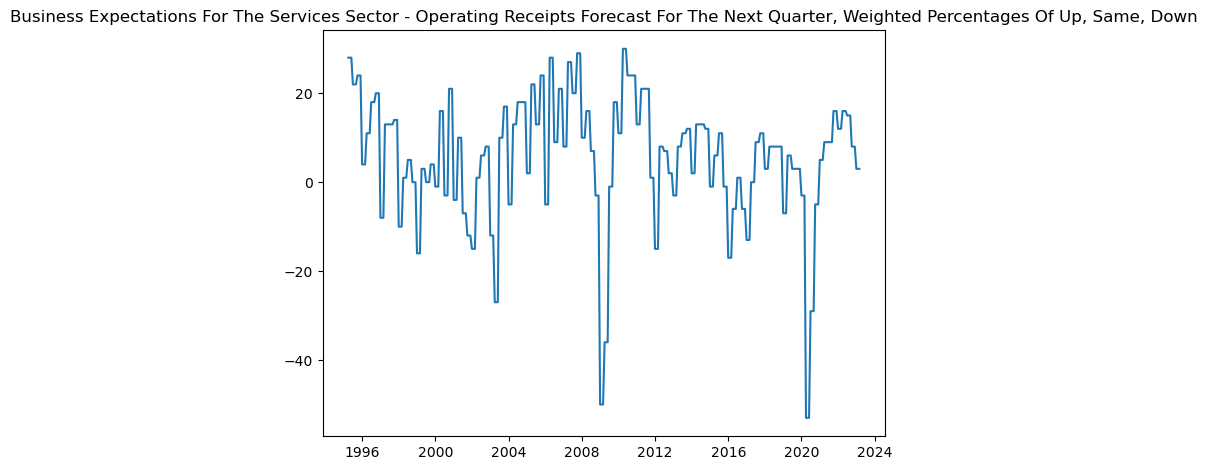

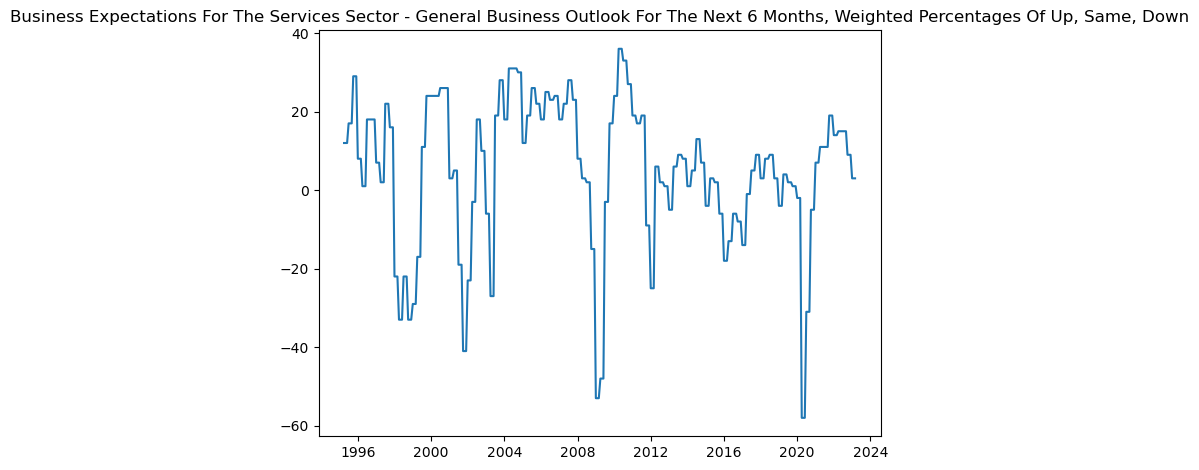

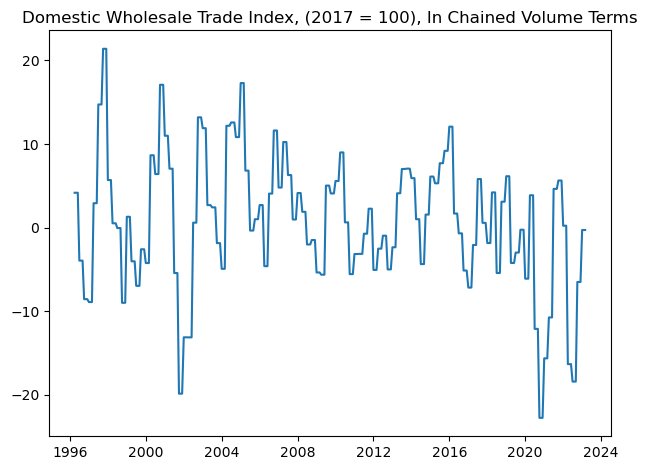

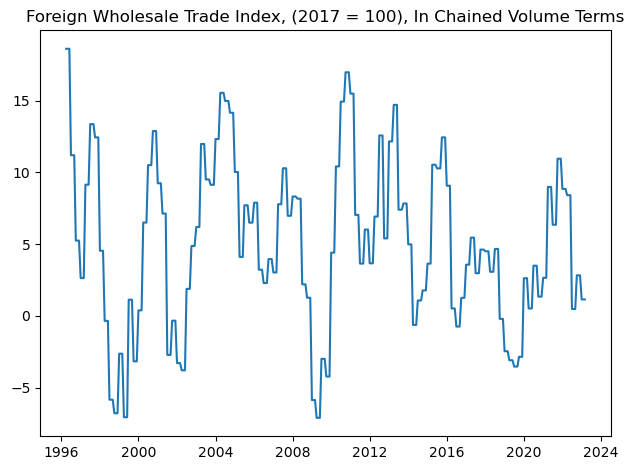

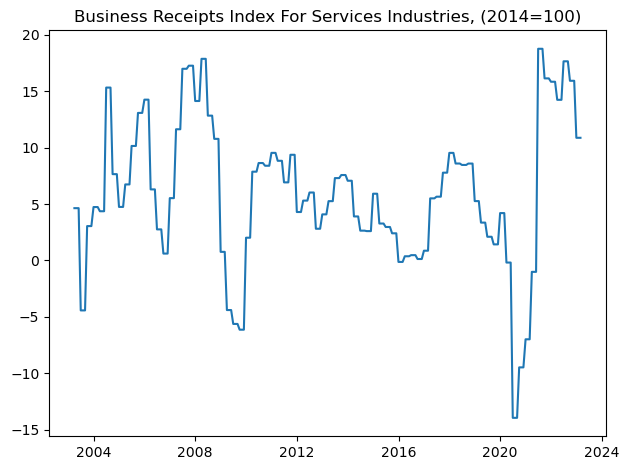

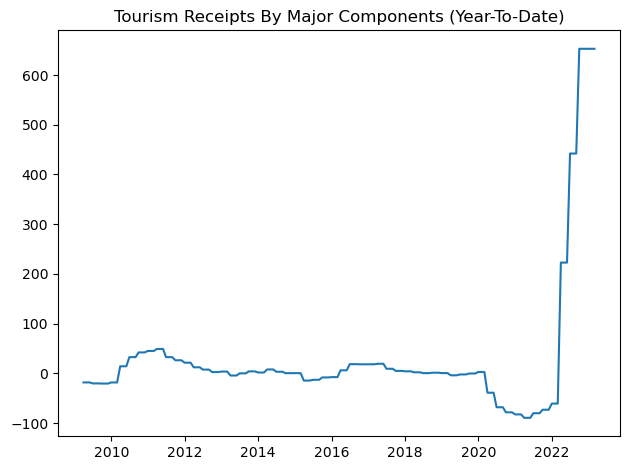

In [22]:
for i in list(ts_df):
    plt.figure()
    plt.title(i)
    plt.plot(ts_df[i].fillna(method='ffill')) # fillna because quarterly data has blanks when freq=monthly
    plt.tight_layout()

Instantiate and fit DF model

In [23]:
# to catch warnings for models that do not converge
warnings.filterwarnings('error', category=UserWarning)

In [24]:
ics = ['aic','bic','hqic']

In [25]:
models = {}
for factor in range(1, max_factors+1):
    for lag in range(1, max_lags+1):
        models[(factor,lag)] = {'model':run_df(ts_df, factor, lag)}

        # if model converges, extract info criterions. if not, remove model from dict.
        if models[(factor,lag)]['model']:
            for ic in ics:
                models[(factor,lag)][ic] = getattr(models[(factor, lag)]['model'], ic)
        else:
            models.pop((factor,lag))

In [26]:
models.keys()

dict_keys([(1, 1), (2, 1), (2, 2), (3, 1), (4, 1)])

Find model with lowest information criterion

In [27]:
models_min_ic = find_min_ic(models)
mod_ic = 'bic'
use_model = models[models_min_ic[mod_ic][0]]

Compare actual vs predicted

<AxesSubplot: title={'center': 'Gross Domestic Product, Year On Year Growth Rate\nDynamic factor model\n(Factors: 2, Order: 1)'}>

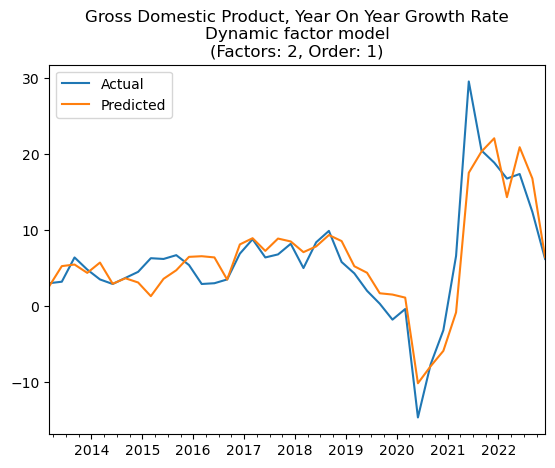

In [28]:
pred = use_model['model'].predict()
compare_df = compare(ts_df, pred)
compare_df.iloc[-(4*10):].plot(title=f"{variables.dep[0]}\nDynamic factor model\n\
(Factors: {models_min_ic[mod_ic][0][0]}, Order: {models_min_ic[mod_ic][0][1]})")

In [29]:
mean_sq_err = mse(compare_df['Actual'], compare_df['Predicted'])
print(f'In-sample MSE of GDP DF forecast: {round(mean_sq_err,3)}')

In-sample MSE of GDP DF forecast: 9.782


Pseudo out-of-sample forecasts, i.e., train on x% of dataset, test on (1-x)%

In [30]:
train_ts, test_ts = split_train_test(ts_df, train_ratio)

In [31]:
oos_models = {}
with np.errstate(divide='ignore'):
    for factor in range(1, max_factors+1):
        for lag in range(1, max_lags+1):
            oos_models[(factor,lag)] = run_train_test(ts_df, train_ts, forecast_steps, factor, lag)

            # if model does not converge, remove from dict
            if not oos_models[(factor,lag)]:
                oos_models.pop((factor,lag))

In [32]:
oos_models.keys()

dict_keys([(1, 1), (2, 1), (2, 2), (3, 1)])

In [33]:
oos_models_min_ic = find_min_ic(oos_models)
oos_ic = 'bic'
use_oos_model = oos_models[oos_models_min_ic[oos_ic][0]]

<AxesSubplot: title={'center': 'Gross Domestic Product, Year On Year Growth Rate\nDynamic factor model\n(Factors: 3, Order: 1)'}>

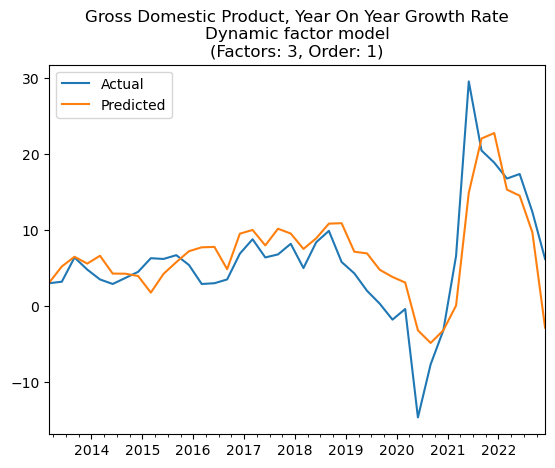

In [34]:
pred_oos = use_oos_model['model'].predict()
compare_oos = compare(ts_df, pred_oos)
compare_oos.iloc[-(4*10):].plot(title=f"{variables.dep[0]}\nDynamic factor model\n\
(Factors: {oos_models_min_ic[oos_ic][0][0]}, Order: {oos_models_min_ic[oos_ic][0][1]})")

In [35]:
mean_sq_err_oos = mse(compare_oos['Actual'], compare_oos['Predicted'])
print(f'Out-of-sample MSE of GDP DF forecast: {round(mean_sq_err_oos,3)}')

Out-of-sample MSE of GDP DF forecast: 12.997


Run an AR model as a baseline vs DF

In [36]:
ar_df = ts_df[variables.dep].dropna()

In [37]:
if adfuller(ar_df[variables.dep[0]])[1]>0.05:
    print(f'[Non-stationary] {variables.dep[0]}')
else:
    print(f'[Stationary] {variables.dep[0]}')

[Stationary] Gross Domestic Product, Year On Year Growth Rate


In [38]:
ar_models = {(p,0,0):None for p in range(1,max_ar)}

In [39]:
for i in ar_models:
    ar_models[i] = {'model':ARIMA(ar_df[variables.dep[0]], order=i).fit()}
    for ic in ics:
        ar_models[i][ic] = getattr(ar_models[i]['model'], ic)

In [40]:
ar_models_min_ic = find_min_ic(ar_models)
ar_ic = 'aic'
use_ar_model = ar_models[ar_models_min_ic[ar_ic][0]]

<AxesSubplot: title={'center': 'Gross Domestic Product, Year On Year Growth Rate\nARIMA\n(p: 6, d: 0, q: 0)'}>

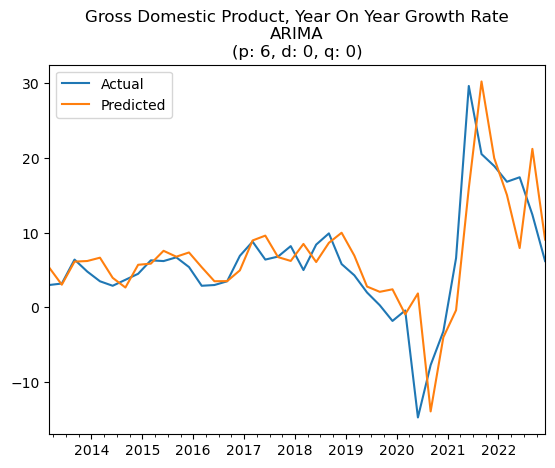

In [41]:
pred_ar = pd.DataFrame(use_ar_model['model'].predict())
pred_ar.columns = variables.dep
compare_ar = compare(ts_df, pred_ar)
compare_ar.iloc[-(4*10):].plot(title=f"{variables.dep[0]}\nARIMA\n\
(p: {ar_models_min_ic[ar_ic][0][0]}, d: {ar_models_min_ic[ar_ic][0][1]}, q: {ar_models_min_ic[ar_ic][0][2]})")

In [42]:
mean_sq_err_ar = mse(compare_ar['Actual'], compare_ar['Predicted'])
print(f'In-sample MSE of GDP AR forecast: {round(mean_sq_err_ar,3)}')

In-sample MSE of GDP AR forecast: 11.418
